# Relax, Inc Analysis Project

Relax, Inc makes productivity and project management software for individuals and teams. In order to better understand which factors are most likely to predict adopted users, I will be analyzing and modeling user data. 

In [1]:
# Import libraries
# ----------------

# Pandas
import pandas as pd

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Numpy
import numpy as np

# Datetime
import datetime

# Scikit Learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Import Data
# ----------------

data1 = 'takehome_users.csv'
data2 = 'takehome_user_engagement.csv'

users = pd.read_csv(data1, encoding='latin-1')
eng = pd.read_csv(data2)

### Cleaning the Data

In [3]:
# Check data for missing informmation
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
# Update columns with missing information
# Convert last_session_creation_time from unix timestamp to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')

# Replace missing last session times with creation time
users['last_session_creation_time'].fillna(users['creation_time'], inplace=True)

# Fill missing invited_by_user_id with 0
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
dtypes: float64(1), int64(4), object(5)
memory usage: 937.6+ KB


In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [6]:
eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Identify Adopted Users

Adopted users is defined as a user who has logged in to the project manager product at least 3 times in a 7 day period.  

In [7]:
# Convert time_stamp to datetime object
eng.set_index('time_stamp', inplace=True)
eng.index = pd.to_datetime(eng.index)

# Group dataframe by users and weekly activity
eng_grouped = eng.groupby('user_id').resample('1W').count()

# Drop duplicate columns
eng_grouped = eng_grouped.drop(columns = ['user_id'])

eng_grouped.head()

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0

In [8]:
# Identify adopted users
adopted_users = eng_grouped[eng_grouped['visited'] >= 3]

# Reset index
adopted_users = adopted_users.reset_index()

# Create a column for adopted users with a value of 1 (will later give non-adopted users a value of 0)
adopted_users['adopted'] = 1

# Add adopted user status to users data
x = adopted_users[['user_id', 'adopted']]
x = x.drop_duplicates(subset = 'user_id')
users_eng = pd.merge(users, x, how='left', left_on='object_id', right_on='user_id')
users_eng = users_eng.drop(columns = 'user_id')

# Replace NaN values in adopted column with 0 for not adopted
users_eng['adopted'] = users_eng['adopted'].fillna(0)

# Create a column for email provider
users_eng['email_provider'] = users_eng['email'].str.split('@').str[1]

# Classify email address domains that occur less than 20 times as 'other'
users_eng = users_eng.assign(email_provider=users_eng.groupby('email_provider')['email_provider'].transform(lambda x: x if x.size>=20 else 'other'))

users_eng.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,email_provider
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0,yahoo.com


### Visualize Data

Adopted Users: 1445.0 (12.0%)


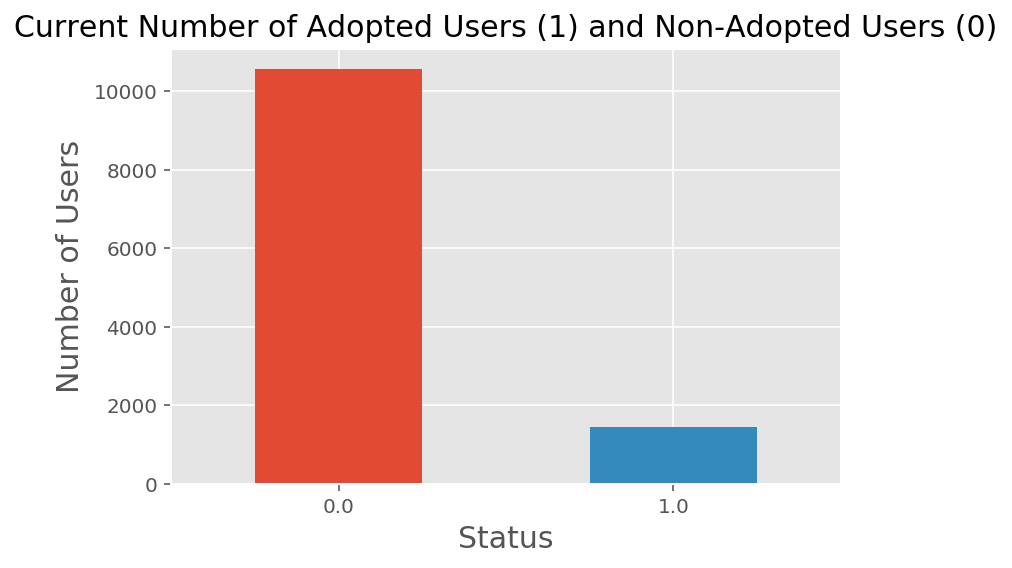

In [9]:
print('Adopted Users: ', users_eng['adopted'].sum(),\
      ' (', round(users_eng['adopted'].mean()*100,1),'%)',sep='')

# Visualize the number of adopted users
users_eng.adopted.value_counts().plot(kind = 'bar')
plt.title('Current Number of Adopted Users (1) and Non-Adopted Users (0)', fontsize=15)
plt.xlabel('Status', fontsize=15)
plt.ylabel('Number of Users', fontsize=15)
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

### Identify Important Features
Now that I have identified the adopted users, I will be using a Random Forest model to identify which features are likely to predict whether a user will become an adopted user. 

In [10]:
# Drop columns that should be excluded from the model 
drop = [
    'object_id',
    'creation_time',
    'name',
    'email',
#    'creation_source',
    'last_session_creation_time',
#    'opted_in_to_mailing_list',
#    'enabled_for_marketing_drip',
#    'org_id',
#    'invited_by_user_id'
    'adopted',
#    'email_provider'
]

# Categorical features to be converted to dummy variables
# if listed here, they cannot be in the 'dropped' list above
dummies = [
    'creation_source',
    'email_provider'
]

# Feature column that identifies whether a user has taken a ride in the previous 30 days
labels = ['adopted']

# Create y variable
y = users_eng['adopted'].values

# Drop Feature columns that will not be used in the model
df_prep = users_eng.drop(columns=drop)

# Create dummy variable columns
df_prep = pd.get_dummies(data=df_prep, columns=dummies)

# feature columns remaining for creating a model
feat_labels = [c for c in df_prep]

# Create X variable
X = df_prep.values

In [11]:
# split data randomly into training and test sets
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

# Build a model
rf = RandomForestClassifier(max_depth=10, random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

errors = abs(y_pred - y_test)

print('Test accuracy: ', 1.0 - round(np.mean(errors), 2), sep='')


# Print the name and importance of each feature, rounded to 2 decimal places
for feature in zip([round(elem, 2) for elem in rf.feature_importances_], feat_labels):
    print(feature)

Test accuracy: 0.88
(0.03, 'opted_in_to_mailing_list')
(0.04, 'enabled_for_marketing_drip')
(0.52, 'org_id')
(0.25, 'invited_by_user_id')
(0.01, 'creation_source_GUEST_INVITE')
(0.02, 'creation_source_ORG_INVITE')
(0.03, 'creation_source_PERSONAL_PROJECTS')
(0.01, 'creation_source_SIGNUP')
(0.0, 'creation_source_SIGNUP_GOOGLE_AUTH')
(0.01, 'email_provider_cuvox.de')
(0.01, 'email_provider_gmail.com')
(0.01, 'email_provider_gustr.com')
(0.02, 'email_provider_hotmail.com')
(0.01, 'email_provider_jourrapide.com')
(0.01, 'email_provider_other')
(0.01, 'email_provider_yahoo.com')


### Conclusion

Of the 12000 users in the original dataset, 1445 (12%) are adopted users and used the program at least 3 days in a 7-day period. 

The most important features in determining whether a users is likely to become and adopted user are: 
* **Org ID:** The organization (or group) that a user belongs to 
* **Invited by User ID:** The ID of the user that invited them to create an account (if applicable)